In [2]:
import wandb
from datasets import load_dataset

CACHE_DATA_SIR = '/NS/twitter-9/work/vnanda/'\
                 'invariances_in_reps/llm/data'

In [3]:
dataset = load_dataset("databricks/databricks-dolly-15k", 
                       cache_dir=CACHE_DATA_SIR)

Found cached dataset json (/NS/twitter-9/work/vnanda/invariances_in_reps/llm/data/databricks___json/databricks--databricks-dolly-15k-55ac4bf59abf58ea/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
len(dataset.data['train'])

15014

In [5]:
dir(dataset.data['train'])

['__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_append_replay',
 '_apply_replays',
 '_batches',
 '_offsets',
 '_schema',
 'add_column',
 'append_column',
 'cast',
 'column',
 'column_names',
 'columns',
 'combine_chunks',
 'drop',
 'equals',
 'fast_gather',
 'fast_slice',
 'field',
 'filter',
 'flatten',
 'from_file',
 'itercolumns',
 'nbytes',
 'num_columns',
 'num_rows',
 'path',
 'remove_column',
 'rename_columns',
 'replace_schema_metadata',
 'replays',
 'schema',
 'select',
 'set_column',
 'shape',
 'slice',
 'table',
 'to_batches',
 'to_pandas',
 'to_pydict',
 'to_pylist',
 'to_reade

In [6]:
dataset.data['train'].column_names

['instruction', 'context', 'response', 'category']

In [8]:
length_context_by_category = {}
length_instruction_by_category = {}
length_response_by_category = {}
num_by_category = {}

for idx, (inst, context, response, category) in enumerate(zip(
    dataset.data['train']['instruction'], dataset.data['train']['context'],
    dataset.data['train']['response'], dataset.data['train']['category'])):
    if idx % 100 == 0:
        print (f'Context: {context}')
        print (f'Instruction: {inst}')
        print (f'Response: {response}')
        print (f'Category: {category}')
        print ()
    
    if str(category) not in num_by_category:
        num_by_category[str(category)] = 1
    else:
        num_by_category[str(category)] += 1
    
    if str(category) not in length_context_by_category:
        length_context_by_category[str(category)] = [len(str(context))]
        length_instruction_by_category[str(category)] = [len(str(inst))]
        length_response_by_category[str(category)] = [len(str(response))]
    else:
        length_context_by_category[str(category)].append(len(str(context)))
        length_instruction_by_category[str(category)].append(len(str(inst)))
        length_response_by_category[str(category)].append(len(str(response)))

Context: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.[3] It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.[4]
Instruction: When did Virgin Australia start operating?
Response: Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.
Category: closed_qa

Context: 
Instruction: I started a new company named Greystone Inc. What do we do?
Response: - Investment banking for weird guys only
- Aerospace consulting
- Pasta and pasta accessory global logistics
- Political lobbying for the mining industry
Category: brainstorming

Context:

In [7]:
length_context_by_category

{'closed_qa': [516,
  1194,
  815,
  662,
  1124,
  978,
  828,
  539,
  571,
  1318,
  514,
  1769,
  660,
  670,
  557,
  3600,
  582,
  1007,
  1034,
  646,
  760,
  398,
  703,
  844,
  414,
  1358,
  745,
  1115,
  618,
  905,
  771,
  464,
  370,
  813,
  1388,
  871,
  498,
  1470,
  1115,
  760,
  619,
  1812,
  573,
  703,
  622,
  857,
  1085,
  1255,
  540,
  1303,
  4466,
  3208,
  786,
  1626,
  528,
  551,
  2342,
  439,
  356,
  1124,
  514,
  643,
  1767,
  999,
  2142,
  664,
  838,
  1393,
  327,
  671,
  1181,
  307,
  985,
  1790,
  544,
  1691,
  315,
  359,
  1643,
  389,
  8851,
  491,
  165,
  2782,
  716,
  548,
  1165,
  676,
  779,
  772,
  4212,
  612,
  951,
  512,
  649,
  1077,
  824,
  1196,
  1421,
  1446,
  1209,
  963,
  283,
  335,
  465,
  4656,
  787,
  943,
  684,
  966,
  1091,
  410,
  1065,
  12672,
  432,
  425,
  986,
  754,
  1233,
  1328,
  691,
  735,
  445,
  477,
  1013,
  636,
  763,
  824,
  4807,
  965,
  721,
  1051,
  1262,
  263,
 

In [13]:
import sys
sys.path.append('..')
import plot_helper as plt_hp
import importlib
importlib.reload(plt_hp)

<module 'plot_helper' from '../plot_helper.py'>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


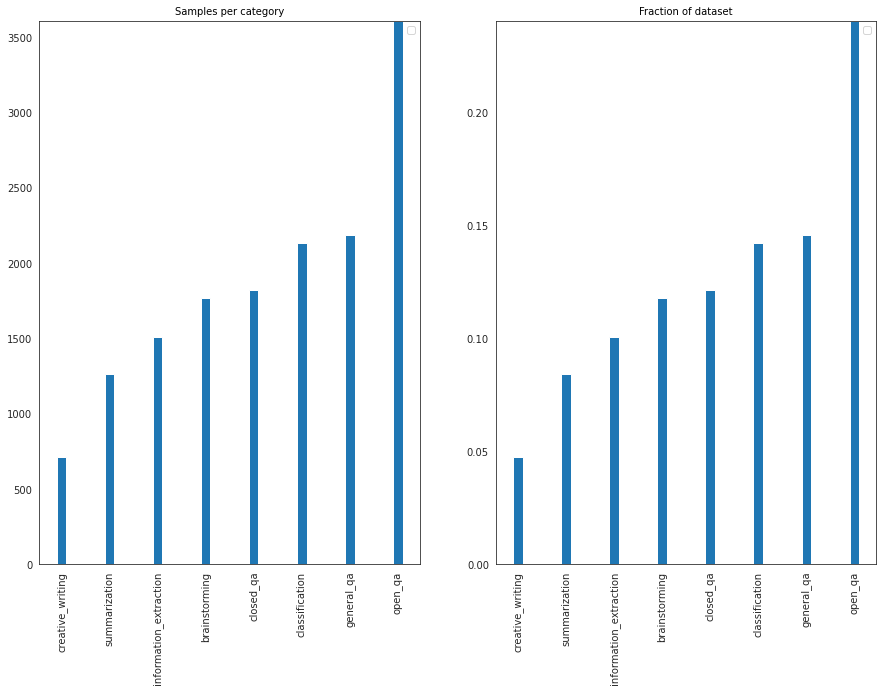

'results/dolly15k/samples_per_category.png'

In [19]:
category, count = list(zip(*sorted(num_by_category.items(), key=lambda x: x[1])))
plt_hp.stitched_bar(
    [[list(count)],[[x/sum(count) for x in count]]], 
    ['Samples per category', 'Fraction of dataset'], 
    'results/dolly15k', 'samples_per_category', 
    'png', [(0., max(count)), (0.,max([x/sum(count) for x in count]))], 
    [category]*2, legend_vals=None, 
    global_title='', columns=2, 
    savefig=True, plot_title_colors=None, figsize=(15,10))

In [31]:
category, length_context = list(zip(*sorted(
    length_context_by_category.items(), key=lambda x: x[0])))
avg_length_context = [sum(x)/len(x) for x in length_context]

_, length_instruction = list(zip(*sorted(
length_instruction_by_category.items(), key=lambda x: x[0])))
avg_length_instruction = [sum(x)/len(x) for x in length_instruction]

_, length_response = list(zip(*sorted(
length_response_by_category.items(), key=lambda x: x[0])))
avg_length_response = [sum(x)/len(x) for x in length_response]


avg_length_context, avg_length_instruction, avg_length_response

([0.0,
  0.0,
  1077.3252879868348,
  0.0,
  0.0,
  1207.3267195767196,
  0.0,
  1291.8606492478227],
 [60.71307300509338,
  123.15823970037454,
  73.1223258365332,
  89.66385372714487,
  74.04381560931081,
  74.85515873015873,
  45.68291332040986,
  56.229612034837686],
 [337.55517826825127,
  141.88436329588015,
  197.74876577070762,
  1001.4106891701829,
  581.4504792332268,
  307.9232804232804,
  288.5721406812517,
  496.83056215360256])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


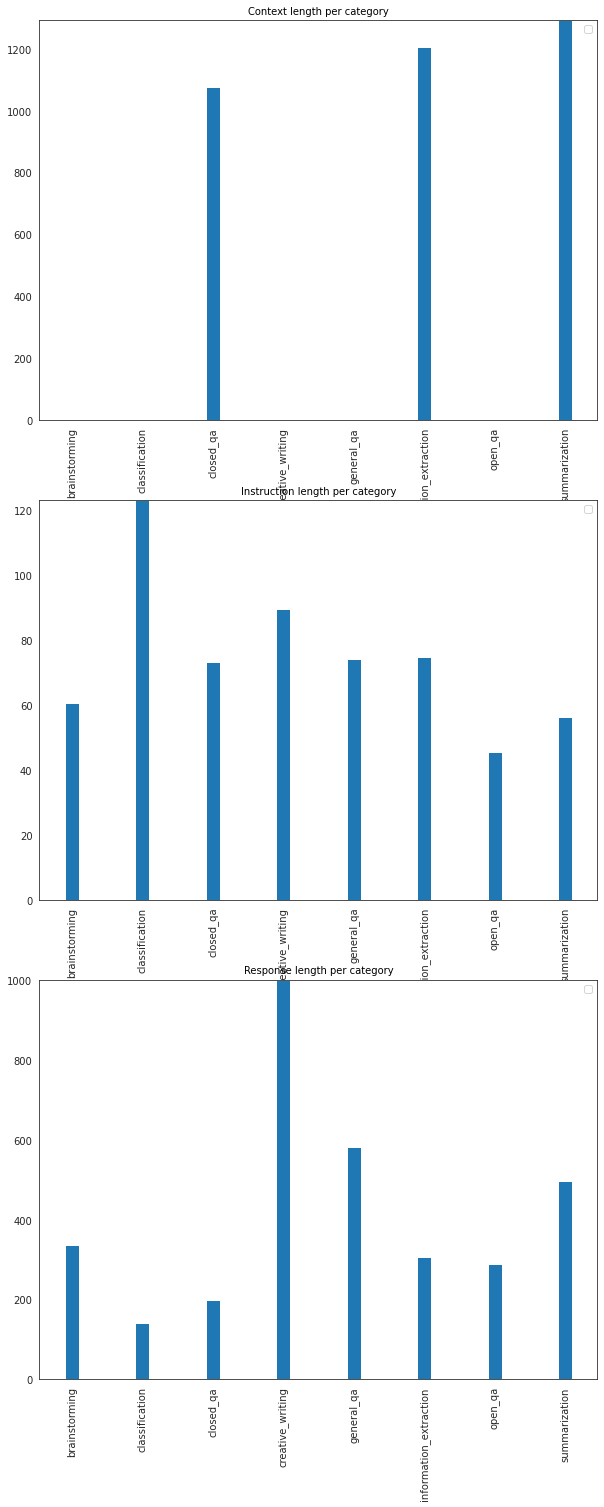

'results/dolly15k/instruction_and_context_length.png'

In [41]:
plt_hp.stitched_bar(
    [[avg_length_context], [avg_length_instruction], [avg_length_response]], 
    ['Context length per category','Instruction length per category', 'Response length per category'], 
    'results/dolly15k', 'instruction_and_context_length', 
    'png', [(0., max(avg_length_context)), (0.,max(avg_length_instruction)), (0.,max(avg_length_response))], 
    [category]*3, 
    legend_vals=None, 
    global_title='', columns=1, 
    savefig=True, plot_title_colors=None, figsize=(10,25))